In [1]:
# -*- coding: utf-8 -*-
"""
Created on Thu Dec 19 17:08:19 2024

@author: Rodrigo Meira
"""
from libs.eos_database import *
from libs.compressor_class import *
from libs.compression import *
from libs.gc_eos_soave import *
from libs.viscosity import *
from libs.plenum_system import *
from libs.simulation import *
from libs.model import *

from casadi import *
import numpy as np
from scipy.optimize import fsolve
import matplotlib.pyplot as plt
import torch
from scipy.stats import qmc
from sklearn.model_selection import train_test_split

In [2]:
list_names = ["CH4", "C2H6", "C3H8", "iC4H10", "nC4H10", "iC5H12", "nC5H12", 
                  "nC6H14", "nC7H16", "nC8H18", "nC9H20", "nC10H22", "nC11H24", 
                   "nC12H26", "nC14H30", "N2", "H2O", "CO2", "C15+"]

nwe = [0.9834, 0.0061, 0.0015, 0.0003, 0.0003, 0.00055, 0.0004, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0003, 0.0, 0.0008, 0.0]

dict_composition= {list_names[i]: nwe[i] for i in range(len(nwe))}

mixture = Mixture(list_of_species, dict_composition)

volumn_desviation = [0] * 19

vlv = valve(kv=0.38)
Vpp = 2.0 
Lc = 2.0 
A1 = 2.6e-3
gas = gc_eos_class(mixture, 300, 4500, None, 1, 0, Aij, volumn_desviation, 'gas')
comp = CompressorClass()
visc = viscosity(mixture, volumn_desviation)
compressor = compression(gas, comp, visc)
plenum_sys = plenum(gas, compressor, vlv, Vpp, Lc, A1)

In [3]:
nAlphas = 300

sampler_N_RotS = qmc.LatinHypercube(d=1)  # d=1 porque estamos amostrando uma única variável
samples_N_RotS = sampler_N_RotS.random(n=nAlphas+1)
N_RotS = qmc.scale(samples_N_RotS, 600, 750).flatten()  # Redimensiona para 1D
sampler_alphas = qmc.LatinHypercube(d=1)
samples_alphas = sampler_alphas.random(n=nAlphas+1)
alphas = qmc.scale(samples_alphas, 0.36, 0.65).flatten()

nData = 40
dt = 2
timestep = 3
x0 = [14.9919, 339.69, 0.42885]
z0 = [6245.39, 6245.39, 321.672, 0.445562, 319.423, 0.503621, 320.097, 0.396345, 339.69, 0.42885, 0.514917]
u0 = [4500, 300, 600, alphas[0], 5000]

In [4]:
# sim = Simulation(plenum_sys, compressor, x0, z0, u0, nAlphas, alphas, N_RotS, nData, dt, timestep)
# x_values, z_values, time_steps, alpha_values, N_values, x_train, y_train, x_min, x_max, y_min,y_max = sim.run()

# sim_data = {
#     "x_values": x_values,
#     "z_values": z_values,
#     "time_steps": time_steps,
#     "x_train": x_train,
#     "y_train": y_train,
#     "x_min": x_min,
#     "x_max": x_max,
#     "y_min": y_min,
#     "y_max": y_max

# }

# np.savez(
#     "simulation_data.npz",
#     x_values=x_values,
#     z_values=z_values,
#     time_steps=time_steps,
#     alpha_values=alpha_values,
#     N_values=N_values,
#     x_train=x_train,
#     y_train=y_train,
#     x_min=x_min,
#     x_max=x_max,
#     y_min = y_min,
#     y_max = y_max

# )


In [5]:
data = np.load("simulation_data.npz")

x_values = data["x_values"]
z_values = data["z_values"]
time_steps = data["time_steps"]
alpha_values = data["alpha_values"]
N_values = data["N_values"]
x_train = data["x_train"]
y_train = data["y_train"]
x_min = data["x_min"]
x_max = data["x_max"]
y_min = data["y_min"]
y_max = data["y_max"]


x_min = torch.tensor(x_min, dtype = torch.float32)
x_max = torch.tensor(x_max, dtype = torch.float32)
y_min = torch.tensor(y_min, dtype = torch.float32)
y_max = torch.tensor(y_max, dtype = torch.float32)
x_train = torch.tensor(np.array(x_train), dtype=torch.float32)
y_train = torch.tensor(np.array(y_train), dtype=torch.float32)
x_train_split, X_val, y_train_split, y_val = train_test_split(
    x_train, 
    y_train, 
    test_size=0.3,  
    random_state=42,  
    shuffle=True      
)
y_train_split = y_train_split.squeeze()
y_val = y_val.squeeze()
train_dataset = torch.utils.data.TensorDataset(x_train_split, y_train_split)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size= 64, shuffle=True)
val_dataset = torch.utils.data.TensorDataset(X_val, y_val)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size= 64, shuffle=False)

In [6]:
model = MyModel(200, dt, x_max, x_min, y_min, y_max, plenum_sys)# Criar a instância do modelo novamente

In [ ]:
# modelo = MyModel(200, dt, x_max, x_min, y_min, y_max, plenum_sys)  # mesma definição usada antes
# modelo.load_state_dict(torch.load('pesos_modelo.pth'))


In [7]:
train_loss_values = model.train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    lr= 1e-4,
    epochs=200,
    optimizers=torch.optim.Adam,
    patience=100,
    factor=0.5,
    gas = gas
)

Batch 0 completed in 5.63s
Batch 1 completed in 3.10s
Batch 2 completed in 3.35s
Batch 3 completed in 3.16s
Batch 4 completed in 3.05s
Batch 5 completed in 2.82s
Batch 6 completed in 2.84s
Batch 7 completed in 2.92s
Batch 8 completed in 2.85s
Batch 9 completed in 3.33s
Batch 10 completed in 3.07s
Batch 11 completed in 2.83s
Batch 12 completed in 2.88s
Batch 13 completed in 2.81s
Batch 14 completed in 2.83s
Batch 15 completed in 2.97s
Batch 16 completed in 2.92s
Batch 17 completed in 2.88s
Batch 18 completed in 2.95s
Batch 19 completed in 2.90s
Batch 20 completed in 3.38s
Batch 21 completed in 2.87s
Batch 22 completed in 2.81s
Batch 23 completed in 2.81s
Batch 24 completed in 2.90s
Batch 25 completed in 2.85s
Batch 26 completed in 2.87s
Batch 27 completed in 2.87s
Batch 28 completed in 2.88s
Batch 29 completed in 2.91s
Batch 30 completed in 2.88s
Batch 31 completed in 3.38s
Batch 32 completed in 2.92s
Batch 33 completed in 2.83s
Batch 34 completed in 2.92s
Batch 35 completed in 2.88s
Ba

/home/matheus/Trabalho/UFBA/New_project/libs/model.py:50: RuntimeWarning: The iteration is not making good progress, as measured by the 
 improvement from the last ten iterations.
  sol = fsolve(self.system_residuals, z0, args=(x0, u0, plenum_sys))


Batch 64 completed in 2.58s
Batch 65 completed in 2.55s
Batch 66 completed in 2.58s
Batch 67 completed in 2.58s
Batch 68 completed in 2.58s
Batch 69 completed in 2.58s
Batch 70 completed in 2.60s
Batch 71 completed in 2.59s
Batch 72 completed in 2.57s
Batch 73 completed in 2.57s
Batch 74 completed in 2.62s
Batch 75 completed in 2.51s
Batch 76 completed in 2.54s
Batch 77 completed in 2.57s
Batch 78 completed in 2.59s
Batch 79 completed in 2.58s
Batch 80 completed in 2.60s
Batch 81 completed in 2.58s
Batch 82 completed in 2.56s
Batch 83 completed in 2.59s
Batch 84 completed in 2.60s
Batch 85 completed in 2.62s
Batch 86 completed in 2.61s
Batch 87 completed in 2.56s
Batch 88 completed in 2.52s
Batch 89 completed in 2.54s
Batch 90 completed in 2.55s
Batch 91 completed in 2.61s
Batch 92 completed in 2.56s
Batch 93 completed in 2.61s
Batch 94 completed in 2.60s
Batch 95 completed in 2.59s
Batch 96 completed in 2.60s
Batch 97 completed in 2.58s
Batch 98 completed in 2.59s
Batch 99 completed i

In [36]:
torch.save(model.state_dict(), 'model.pth')


In [62]:
nAlphas_teste = 7

sampler_N_RotS_teste = qmc.LatinHypercube(d=1)  # d=1 porque estamos amostrando uma única variável
samples_N_RotS_teste = sampler_N_RotS_teste.random(n=nAlphas_teste+1)
N_RotS_teste = qmc.scale(samples_N_RotS_teste, 600, 750).flatten()  # Redimensiona para 1D
sampler_alphas_teste = qmc.LatinHypercube(d=1)
samples_alphas_teste = sampler_alphas_teste.random(n=nAlphas_teste+1)
alphas_teste = qmc.scale(samples_alphas_teste, 0.35, 0.65).flatten()  

sim2 = sim = Simulation(plenum_sys, compressor, x0, z0, u0, nAlphas_teste, alphas_teste, N_RotS_teste, 40, dt, timestep)
x_values_teste, z_values_teste, time_steps, alpha_values_teste, N_values_teste, x_teste, y_teste, x_min, x_max, y_min, y_max = sim.run()
x_teste_np = x_teste.reshape(1,277, 3, 7)

In [63]:
import torch

# Rodar a inferência corretamente
model.eval()  # Importante colocar a rede em modo de avaliação
with torch.no_grad():
    y_pred = model(x_teste)

# Checar se y_pred realmente varia
for name, param in model.named_parameters():
    print(f"{name}: mean={param.mean().item()}, std={param.std().item()}")



rnn_layer.weight_ih_l0: mean=-0.0005358439520932734, std=0.068048857152462
rnn_layer.weight_hh_l0: mean=-0.0030979523435235023, std=0.05810977891087532
rnn_layer.bias_ih_l0: mean=0.006718325428664684, std=0.049324680119752884
rnn_layer.bias_hh_l0: mean=0.009253427386283875, std=0.04752092808485031
dense_layers.0.weight: mean=0.0001650081539992243, std=0.05166690796613693
dense_layers.0.bias: mean=0.002711245324462652, std=0.04084060341119766
dense_layers.2.weight: mean=-0.009335032664239407, std=0.12962868809700012
dense_layers.2.bias: mean=0.0024202412459999323, std=0.06388068944215775


In [52]:
torch.onnx.export(
    model,
    x_teste,
    "modelo_simples.onnx",
    export_params=True,
    opset_version=17,
    input_names=["input"],
    output_names=["output"],
    dynamic_axes={
        "input": {0: "batch_size"},  # Permite batch variável
        "output": {0: "batch_size"},
    },
)

/home/matheus/.local/lib/python3.12/site-packages/torch/onnx/symbolic_opset9.py:4277: UserWarning: Exporting a model to ONNX with a batch_size other than 1, with a variable length with LSTM can cause an error when running the ONNX model with a different batch size. Make sure to save the model with a batch size of 1, or define the initial states (h0/c0) as inputs of the model. 
  warnings.warn(


In [67]:
import onnxruntime as ort
import numpy as np

# Converter o tensor para NumPy e ajustar o dtype
x_teste_np = x_teste.detach().cpu().numpy().astype(np.float32)  # Garanta float32

# Se o modelo esperar um batch dimension (ex: [batch, seq_len, features]), adicione:
if x_teste_np.ndim == 1:
    x_teste_np = x_teste_np[np.newaxis, ...]  # Adiciona dimensão de batch (batch=1)

# Carregar o modelo ONNX
ort_session = ort.InferenceSession("modelo_simples.onnx")

# Executar inferência corretamente
input_name = ort_session.get_inputs()[0].name
outputs = ort_session.run(None, {input_name: x_teste_np})[0]

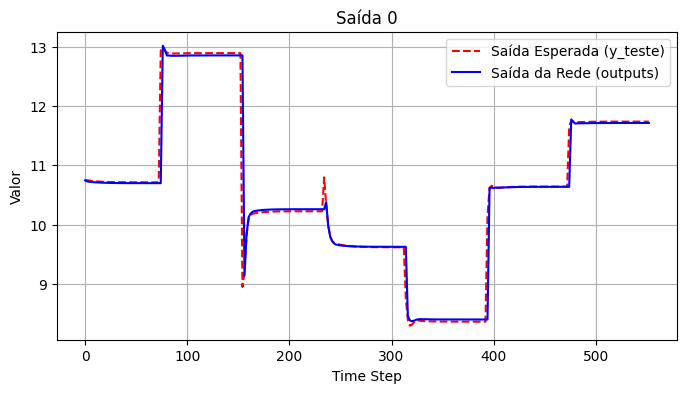

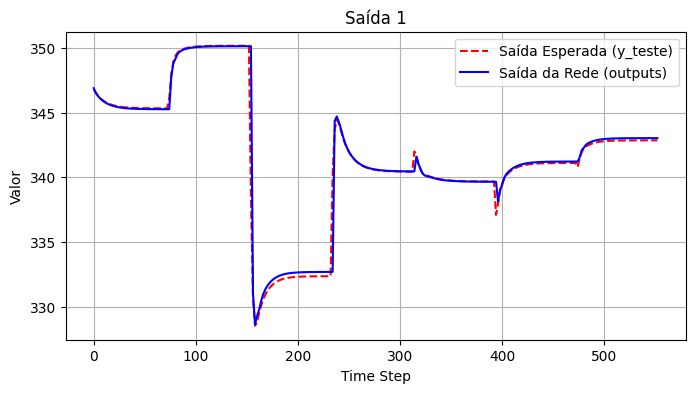

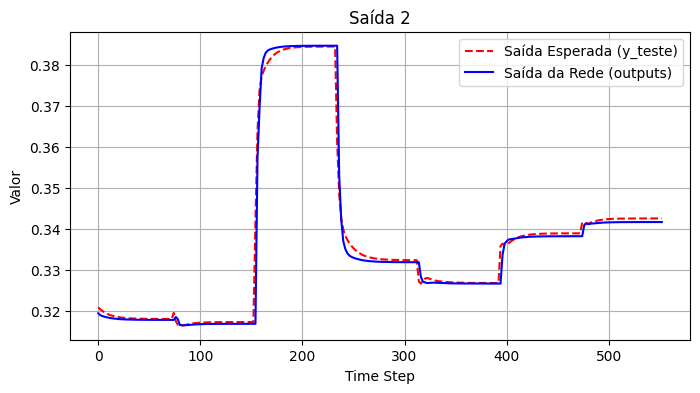

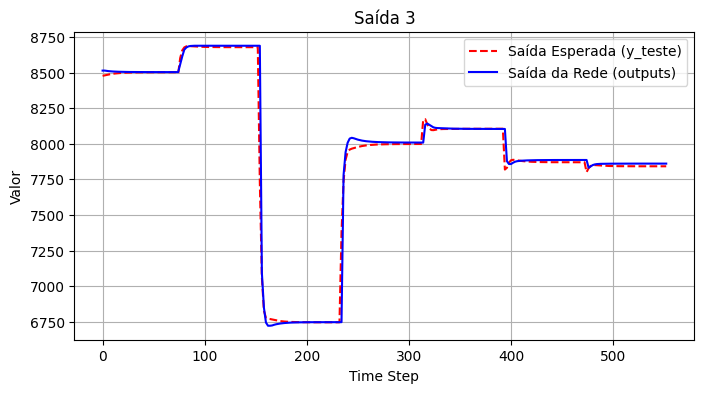

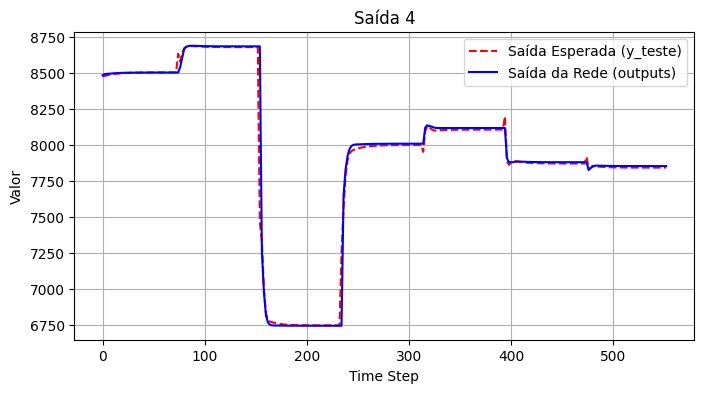

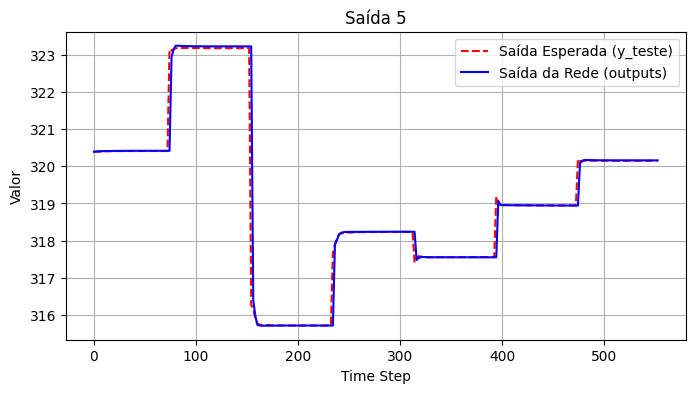

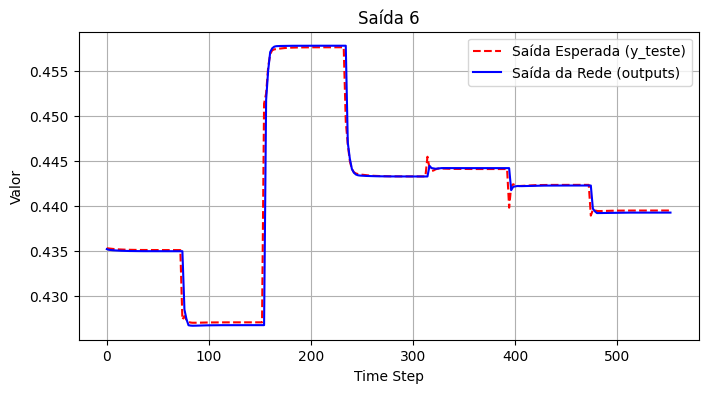

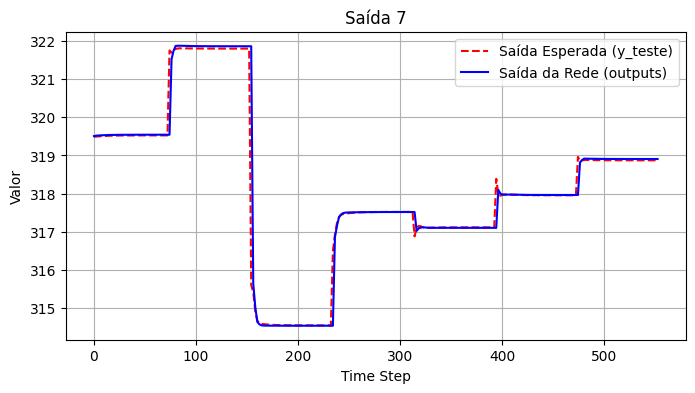

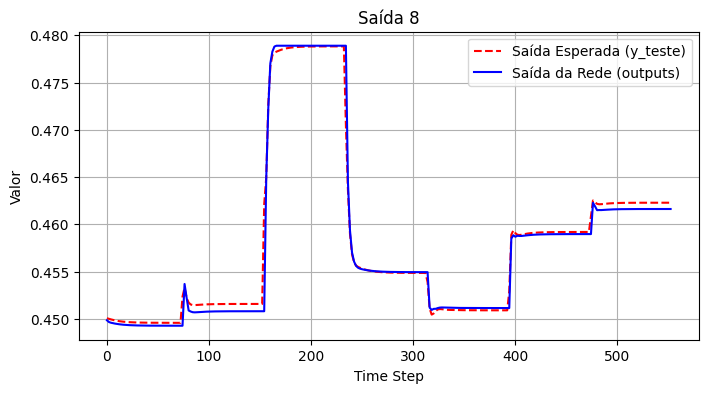

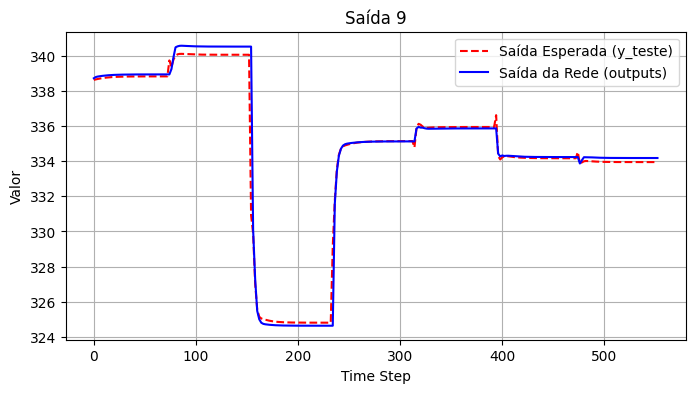

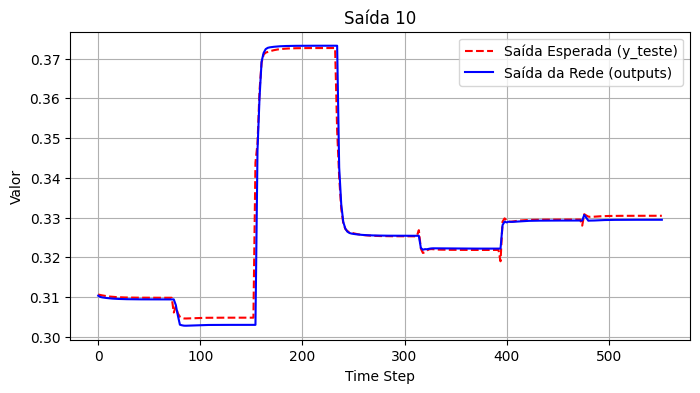

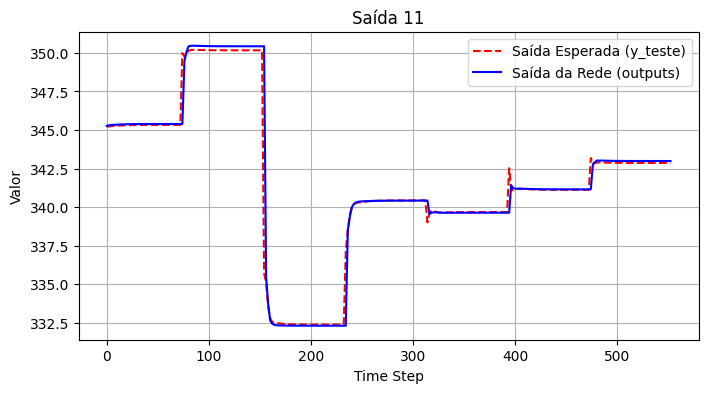

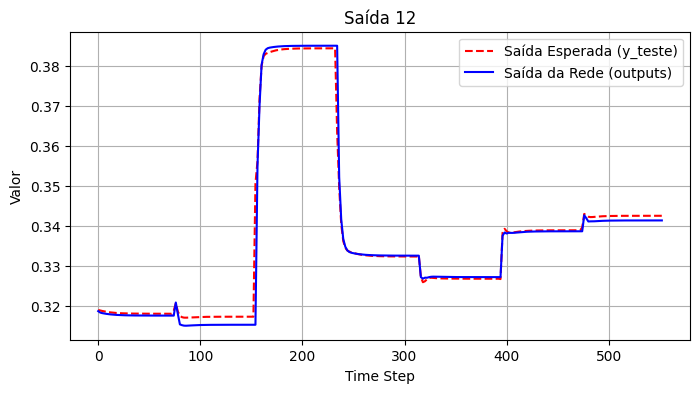

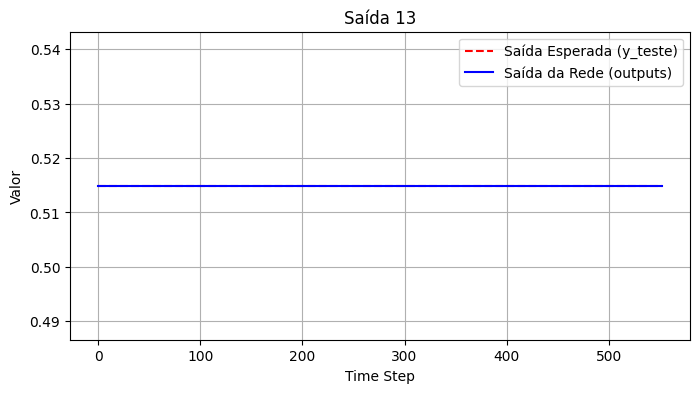

'[0, 1, 2, 3, 5, 7, 9, 11]'

In [70]:
import matplotlib.pyplot as plt

# Remover dimensões extras de y_pred e y_teste (se houver)
outputs = outputs.squeeze()
y_teste = y_teste.squeeze()

# Número de variáveis de saída
num_outputs = y_teste.shape[1]

# Ajustar o tamanho da lista time_steps para corresponder aos dados de teste
time_steps = time_steps[:y_teste.shape[0]]
 
# Criar os gráficos separadamente para cada saída
for i in range(num_outputs):
    plt.figure(figsize=(8, 4))  # Criar uma nova figura para cada gráfico
    plt.plot(time_steps, y_teste[:, i], label="Saída Esperada (y_teste)", color="red", linestyle="--")
    plt.plot(time_steps, outputs[:, i], label="Saída da Rede (outputs)", color="blue", linestyle="-")
    
    plt.xlabel("Time Step")
    plt.ylabel("Valor")
    plt.title(f"Saída {i}")  # Título do gráfico indicando o índice da saída
    plt.legend()
    plt.grid(True)
    
    plt.show()  # Mostrar o gráfico

"[0, 1, 2, 3, 5, 7, 9, 11]"